<a href="https://colab.research.google.com/github/szeshiang/Deep-Learning/blob/main/23_Mar_24_PyTorch_Ex_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Objective of this exercise: To create ANN using PyTorch on Fashion MNIST Dataset**

In [1]:
# import library
import torch
import numpy as np
import torch.nn as nn # All neural netrwork
import torch.optim as optim # Various optmization algo
import torch.nn.functional as F # Non Linear activation function
from torchvision import datasets,transforms # Download datasets, transform images
from torch.utils.data.sampler import SubsetRandomSampler # split the dataset
print('All library imported')

All library imported


**Process**

1. Load & Visualize the data
2. Pre process the data
3. Define model using PyTorch
4. Train the model
5. Save the best model
6. Test the model

**Three Steps ETL**

1. Extract- Get the Fashion MNIST dataset from the source
2. Transform- Put the data into tensor form
3. Load- Put the data into an object


In [2]:
transform=transforms.Compose([transforms.ToTensor(),
                             transforms.Normalize((0.5,),(0.5,),)])

In [3]:
# Load the data -train and test set
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=True,transform=transform) # 60,000 datasets (80%)
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=False,transform=transform) # 10,000 datasets (20%)
print('Data loaded')

100%|██████████| 26421880/26421880 [00:01<00:00, 15689214.89it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 266226.70it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4992381.30it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22260079.37it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw

Data loaded


**Trainset**

In [6]:
# load the dataset
indices=list(range(len(trainset)))
np.random.shuffle(indices)

# 80% of train set-validation data; train: test is 8:2 of the train (80% of whole datasets)
split=int(np.floor(0.8*len(trainset)))
train_sample=SubsetRandomSampler(indices[:split])
valid_sample=SubsetRandomSampler(indices[split:])

# data loader
trainloader=torch.utils.data.DataLoader(trainset,sampler=train_sample,batch_size=64)
validloader=torch.utils.data.DataLoader(trainset,sampler=valid_sample,batch_size=64)
testloader=torch.utils.data.DataLoader(testset,batch_size=64,shuffle=True)

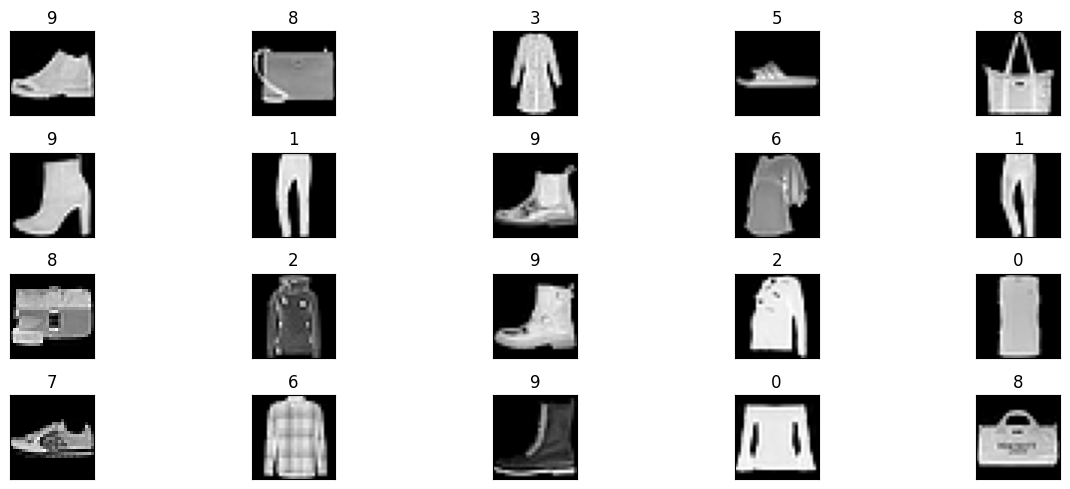

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
# get some random training images
dataiter = iter(trainloader)
print(dataiter)
#images, labels = dataiter.next()

images, labels = next(dataiter)

#images, labels = trainloader

fig = plt.figure(figsize=(15,5))
for idx in np.arange(20):
  # xticks=[], yticks=[] is empty to print the images without any ticks around them
  #np.sqeeze : Remove single-dimensional entries from the shape of an array.
  ax = fig.add_subplot(4,5, idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='gray')
   # .item() gets the value contained in a Tensor
  ax.set_title(labels[idx].item())
  fig.tight_layout()

In [8]:
trainset.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [10]:
# Build the Neural Network
class Classifier(nn.Module):                        # Classifier is a class
    def __init__(self):                             # constructor
        super().__init__()                          # super = only 1 base/module. if there are more modules, to be specific instead of super
        self.fc1=nn.Linear(784,120) # i*w+b         # ANN, CNN, etc, layers depending
        self.fc2=nn.Linear(120,120)
        self.fc3=nn.Linear(120,10)
        self.dropout=nn.Dropout(0.2)

    def forward(self,x):                            # feed-forward NN
        x=x.view(x.shape[0],-1)
        x=self.dropout(F.relu(self.fc1(x)))
        x=self.dropout(F.relu(self.fc2(x)))
        # output layer
        x=F.log_softmax(self.fc3(x),dim=1)
        return x

In [11]:
model=Classifier()
# define the loss function
criterion=nn.NLLLoss()                              # Neg-Log Likelihood ~ Cross-Entropy (sum of all correct log possibilities)
optimizer=optim.SGD(model.parameters(),lr=0.01)

valid_loss_min=np.Inf # using this value to make sure the update weight first time
epochs=10
steps=0
model.train() # Prepare model for training
train_losses,valid_losses=[],[]

**Difference between using Keras vs PyTorch in training model**

in Keras, we use model.compile and model.fit to build and run the model

in PyTorch, we use for-loop, using trainloader to iterate the data
1. more programming to write and allows scientist to bespoke the model

In [12]:
for e in range(epochs):
    running_loss=0
    valid_loss=0
    # to train the model
    for images,labels in trainloader:
        optimizer.zero_grad()
        log_ps=model(images)                       # forward pass
        loss=criterion(log_ps,labels)              # compute the loss
        loss.backward()                            # calculate the gradients
        optimizer.step()                           # model parameters update
        running_loss+=loss.item()*images.size(0)
    for images,labels in validloader:              # using the trained model to determine the loss and accuracy
        log_ps=model(images)
        loss=criterion(log_ps,labels)
        valid_loss+=loss.item()*images.size(0)

    running_loss=running_loss/len(trainloader.sampler)   # these 4 rows are to accummulate all the losses
    valid_loss=valid_loss/len(validloader.sampler)
    train_losses.append(running_loss)
    valid_losses.append(valid_loss)

    print('Epoch:{} \t Training Loss:{:.6f} \t validation Loss:{:.6f}'.
         format(e+1,running_loss,valid_loss))

    if valid_loss <= valid_loss_min:
      print('validation loss decreased({:.6f} -->{:.6f}). Saving Model ...'.format(valid_loss_min, valid_loss))
      torch.save(model.state_dict(), 'model.pt')
      valid_loss_min = valid_loss

Epoch:1 	 Training Loss:1.242613 	 validation Loss:0.784104
validation loss decreased(inf -->0.784104). Saving Model ...
Epoch:2 	 Training Loss:0.702209 	 validation Loss:0.636541
validation loss decreased(0.784104 -->0.636541). Saving Model ...
Epoch:3 	 Training Loss:0.607683 	 validation Loss:0.570158
validation loss decreased(0.636541 -->0.570158). Saving Model ...
Epoch:4 	 Training Loss:0.549506 	 validation Loss:0.536362
validation loss decreased(0.570158 -->0.536362). Saving Model ...
Epoch:5 	 Training Loss:0.518189 	 validation Loss:0.515787
validation loss decreased(0.536362 -->0.515787). Saving Model ...
Epoch:6 	 Training Loss:0.492287 	 validation Loss:0.486241
validation loss decreased(0.515787 -->0.486241). Saving Model ...
Epoch:7 	 Training Loss:0.471755 	 validation Loss:0.471098
validation loss decreased(0.486241 -->0.471098). Saving Model ...
Epoch:8 	 Training Loss:0.456103 	 validation Loss:0.455574
validation loss decreased(0.471098 -->0.455574). Saving Model .

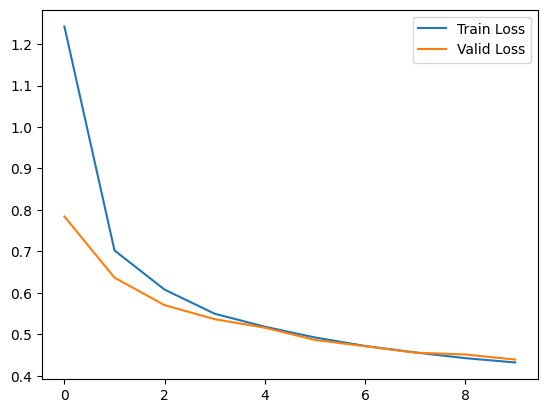

In [13]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')

plt.legend()

**Predicting results and testing accuracy (using test set)**

In [14]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [15]:
#track the test loss
test_loss = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

In [16]:
model.eval()
for images, labels in testloader:
  #forward pass
  output = model(images)
  #calculate the loss
  loss = criterion(output, labels)
  #update the test loss
  test_loss += loss.item()*images.size(0)
  # convert output probabilities to predicted class
  _, pred = torch.max(output, 1)
  #compare predictions to the true labes
  correct = np.squeeze(pred.eq(labels.data.view_as(pred)))
  #calculate test accuracy for each object class
  for i in range(len(labels)):
    label = labels.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] +=1

#calcaulate and prınt test loss
test_loss = test_loss/len(testloader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
  if class_total[i] > 0:
    print('Test Accuracy of %5s: %2d%% (%2d/%2d)'%
          (str(i), 100 * class_correct[i]/class_total[i],
           np.sum(class_correct[i]), np.sum(class_total[i])))
  else:
    print('Test Accuracy of %5s: N/A(no training examples)' % classes[i])

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.425496

Test Accuracy of     0: 83% (831/1000)
Test Accuracy of     1: 94% (948/1000)
Test Accuracy of     2: 71% (714/1000)
Test Accuracy of     3: 86% (860/1000)
Test Accuracy of     4: 74% (744/1000)
Test Accuracy of     5: 89% (895/1000)
Test Accuracy of     6: 62% (622/1000)
Test Accuracy of     7: 92% (927/1000)
Test Accuracy of     8: 95% (953/1000)
Test Accuracy of     9: 93% (933/1000)

Test Accuracy (Overall): 84% (8427/10000)


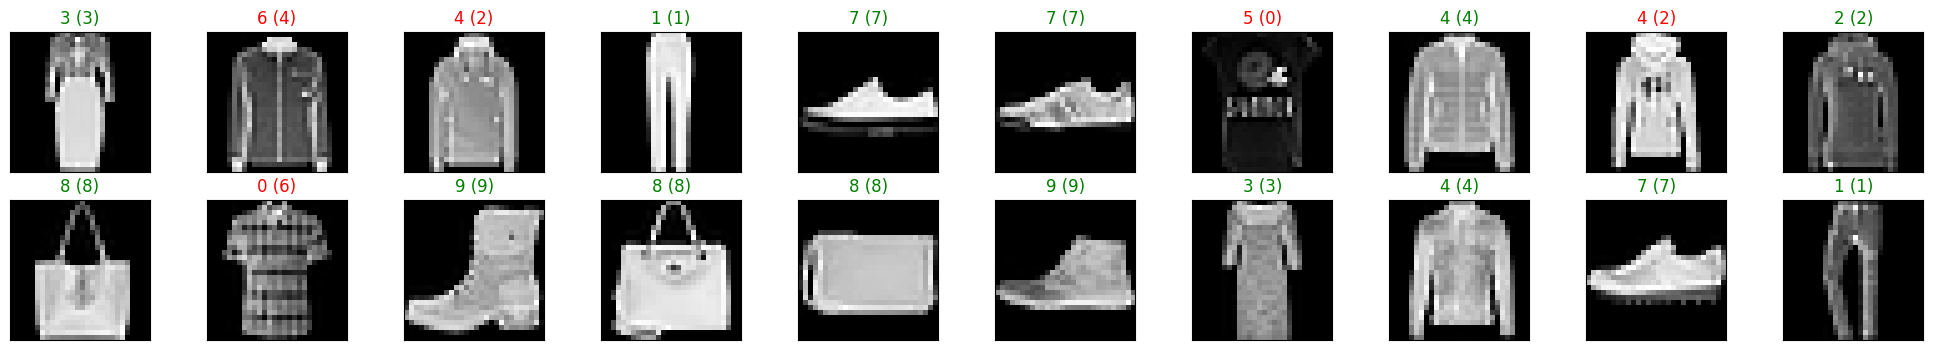

In [17]:
# obtain one batch of test images
dataiter = iter(testloader)
#images, labels = dataiter.next()
images, labels = next(dataiter)
# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

In [18]:
trainset.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']